In [1]:
import numpy as np
import os
import cv2

import vista
from vista.utils import transform
from vista.entities.agents.Dynamics import tireangle2curvature
import matplotlib.pyplot as plt

2023-04-29 23:09:53,431::WARNING::[d:\Research\MIT DRL\VISTA\vista\entities\sensors\EventCamera.<module>] Fail to import module for event camera. Remember to do source <some-dir>/openeb/build/utils/scripts/setup_env.shCan ignore this if not using it


In [2]:
def follow_human_trajectory(agent):
    action = np.array([
        agent.trace.f_curvature(agent.timestamp),
        agent.trace.f_speed(agent.timestamp)
    ])
    return action


def pure_pursuit_controller(agent):
    # hyperparameters
    lookahead_dist = 5.
    Kp = 3.
    dt = 1 / 30.

    # get road in ego-car coordinates
    ego_pose = agent.ego_dynamics.numpy()[:3]
    road_in_ego = np.array([
        transform.compute_relative_latlongyaw(_v[:3], ego_pose)
        for _v in agent.road
    ])

    # find (lookahead) target
    dist = np.linalg.norm(road_in_ego[:, :2], axis=1)
    dist[road_in_ego[:, 1] < 0] = 9999.  # drop road in the back
    tgt_idx = np.argmin(np.abs(dist - lookahead_dist))
    dx, dy, dyaw = road_in_ego[tgt_idx]

    # simply follow human trajectory for speed
    speed = agent.human_speed

    # compute curvature
    arc_len = speed * dt
    curvature = (Kp * np.arctan2(-dx, dy) * dt) / arc_len
    curvature_bound = [
        tireangle2curvature(_v, agent.wheel_base)
        for _v in agent.ego_dynamics.steering_bound
    ]
    curvature = np.clip(curvature, *curvature_bound)

    return np.array([curvature, speed])


In [ ]:
trace_paths = ["./vista_traces/20210726-131322_lexus_devens_center/"]
world = vista.World(trace_paths,
                    trace_config={'road_width': 4})
car = world.spawn_agent(config={'length': 5.,
                                'width': 2.,
                                'wheel_base': 2.78,
                                'steering_ratio': 14.7,
                                'lookahead_road': True})
display = vista.Display(world)

state_space_controller = [follow_human_trajectory, pure_pursuit_controller][1]

world.reset()
display.reset()

while not car.done:
    action = state_space_controller(car)
    car.step_dynamics(action)

    vis_img = display.render()
    plt.imshow(vis_img)
    plt.show()



2023-04-29 23:07:43,537::WARNING::[d:\Research\MIT DRL\VISTA\vista\core\Trace._divide_to_good_segments] No video_label.csv


2023-04-29 14:08:30,899::WARNING::[d:\Research\MIT DRL\VISTA\vista\core\Trace._divide_to_good_segments] No video_label.csv


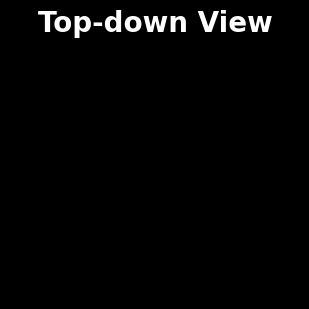

In [2]:
import vista

trace_paths = ["./vista_traces/20210726-131322_lexus_devens_center/"]
world = vista.World(trace_paths,
                    trace_config={'road_width': 4})
car = world.spawn_agent(config={'length': 5.,
                                'width': 2.,
                                'wheel_base': 2.78,
                                'steering_ratio': 14.7,
                                'lookahead_road': True})
display = vista.Display(world)

In [7]:
import numpy as np
import matplotlib.pyplot as plt

frames = []
cap = cv2.VideoCapture('./vista_traces/20210726-131912_lexus_devens_center_reverse/camera_front.avi')
while True:
    read, frame= cap.read()
    if not read:
        break
    frames.append(frame)
    break
frames = np.array(frames)
cv2.imshow('Visualize event data', frames[0])
cv2.waitKey(1)

-1

: 